In [44]:
import os
from os.path import join
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import keras
from keras import layers, Input, models
import matplotlib
from matplotlib import font_manager, rc, gridspec
import matplotlib.pyplot as plt
import warnings
import itertools
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D
from tensorflow.keras.layers import Flatten, Softmax, SpatialDropout2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow_addons.metrics
import cv2
import random
from tqdm.keras import TqdmCallback
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
#warnings.filterwarnings("ignore")

In [2]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [3]:
# 환경 설정
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
#print(font_list[:])
%matplotlib inline


In [4]:
import mapply
mapply.init(
    n_workers=-1,
    chunk_size=100,
    max_chunks_per_worker=16,
    progressbar=True
)
tqdm.pandas()

font_path = '/usr/share/fonts/NanumGothic.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rc('font', family='NanumGothic')

In [5]:
#최초 실행시에만 True
is_first = False

In [6]:
# GPU 메모리 최대 사용을 막기 위한 memory_growth  설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
#최초 실행시 전체 데이터 로드
if is_first:
    df=pd.read_pickle("LSWMD.pkl")
    df.info()

In [8]:
#라벨링 필드 치환을 위한 맵핑 선언
LabelMapping = {
    'Center':0,
    'Donut':1,
    'Edge-Loc':2,
    'Edge-Ring':3,
    'Loc':4,
    'Random':5,
    'Scratch':6,
    'Near-full':7,
    'none':8
}

In [9]:
#불량 타입에 대한 라벨링 적용
if is_first:
    df['failureNum']=df.failureType
    df = df.replace({'failureNum':LabelMapping})

In [10]:
if is_first:
    print('라벨링이 있는 건수 : ', len(df[(df['failureNum']>=0) & (df['failureNum']<=7)]))
    print('라벨링이 없는 건수 : ', len(df[df['failureNum']==8]))

In [11]:
#학습에 사용될 실제 데이터 로드
if is_first:
    df_wafermap = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
    df_wafermap = df_wafermap.reset_index()
    df_wafermap.to_pickle('LSWMD_wafermap.pkl')
else:
    df_wafermap = pd.read_pickle("LSWMD_wafermap.pkl")

In [12]:
#불량 라벨의 array 데이터를 중첩루프에서 string 추출
df_wafermap['failureType'] = df_wafermap['failureType'].apply(lambda x: list(itertools.chain.from_iterable(x))[0])
df_wafermap['trianTestLabel'] = df_wafermap['trianTestLabel'].apply(lambda x: list(itertools.chain.from_iterable(x))[0])

In [13]:
#불량 패턴만 추출
plt_label_values = np.unique(df_wafermap[(df_wafermap['failureNum']>=0) 
                                         & (df_wafermap['failureNum']<=7)].failureNum, return_counts=True)
df_label_values = df_wafermap[(df_wafermap['failureNum']>=0) & (df_wafermap['failureNum']<=7)]
df_label_values = df_label_values.reset_index()

/tmp/ipykernel_640487/1968714749.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


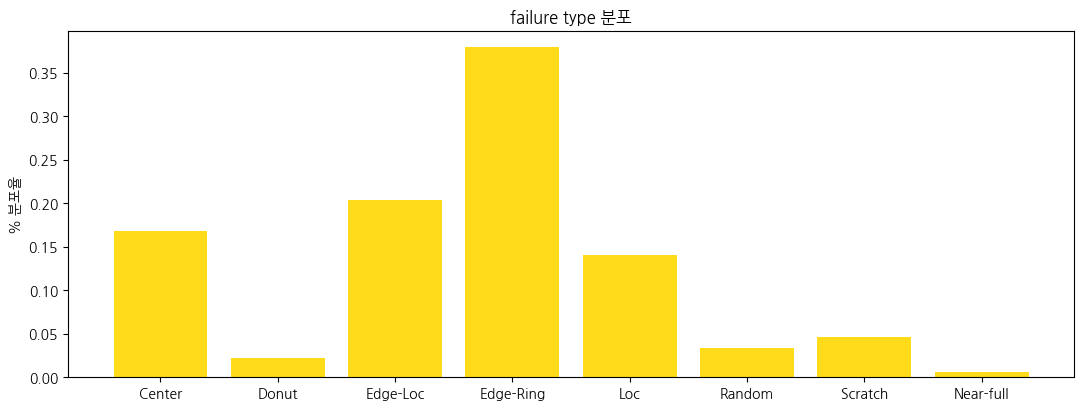

In [14]:
#불량 종류 시각화
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax = plt.subplot(gs[1])
labels = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax.bar(plt_label_values[0],plt_label_values[1]/df_label_values.shape[0], color='gold', align='center', alpha=0.9)
ax.set_title("failure type 분포")
ax.set_ylabel("% 분포율")
ax.set_xticklabels(labels)
plt.show()

In [ ]:
#불량 종류 시각화 - 2
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_label_values.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_label_values.failureType[i], fontsize=10)
    ax[i].set_xlabel(df_label_values.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

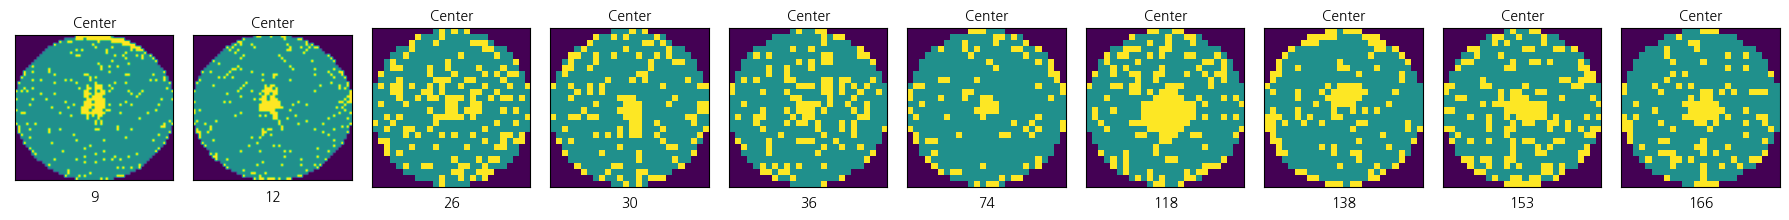

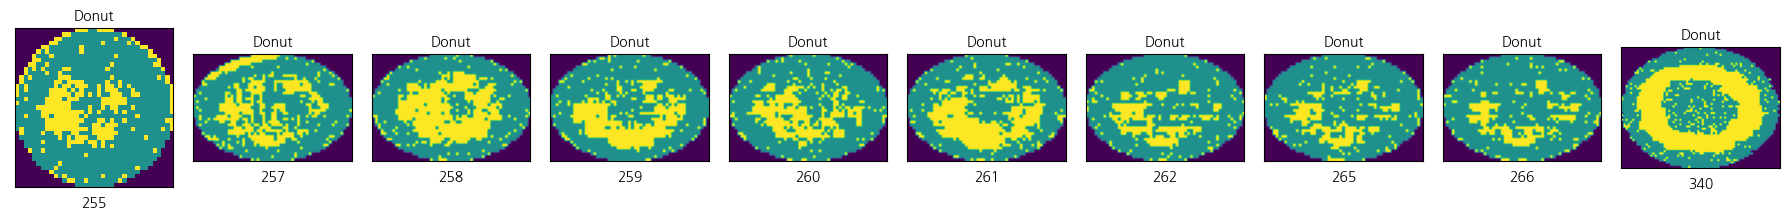

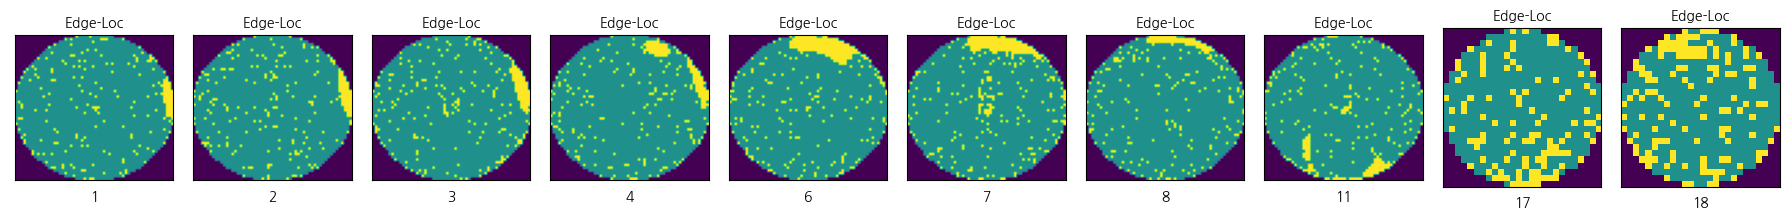

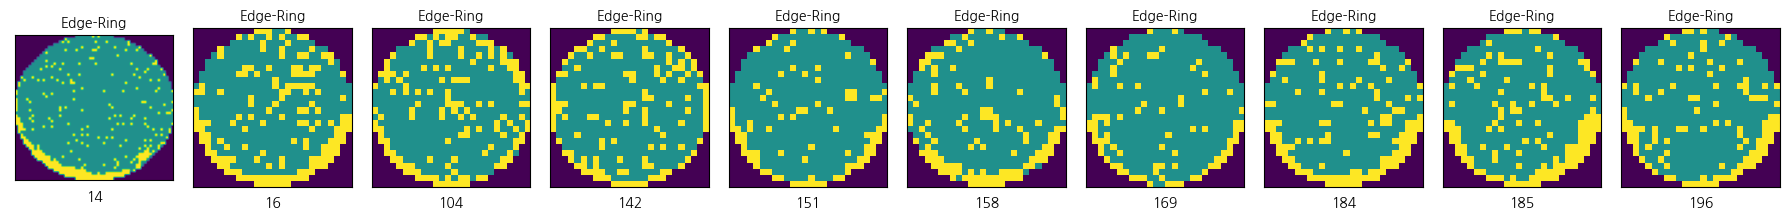

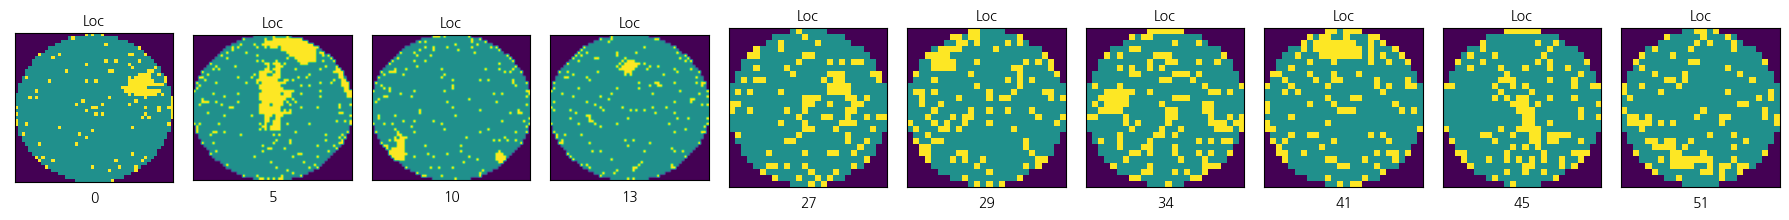

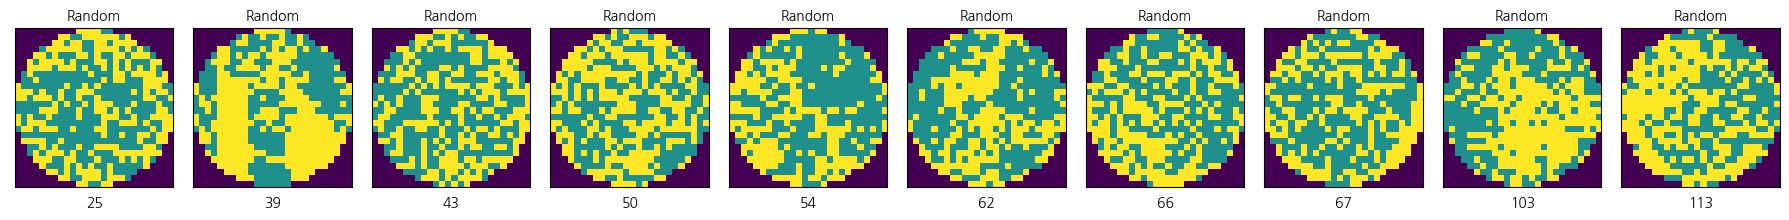

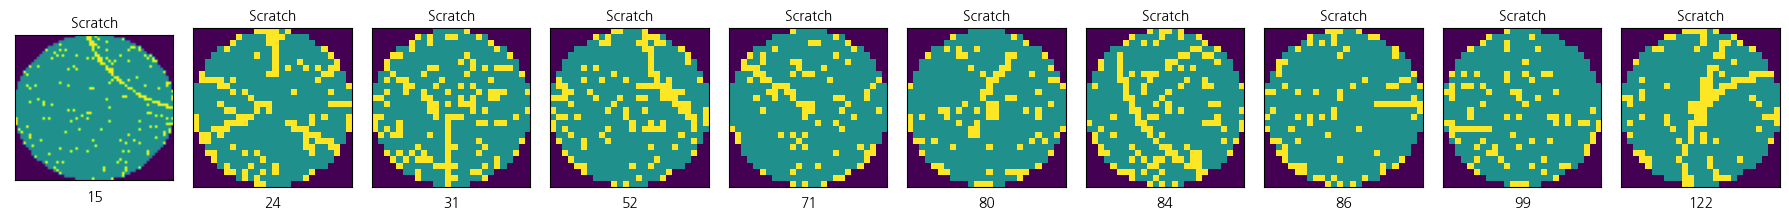

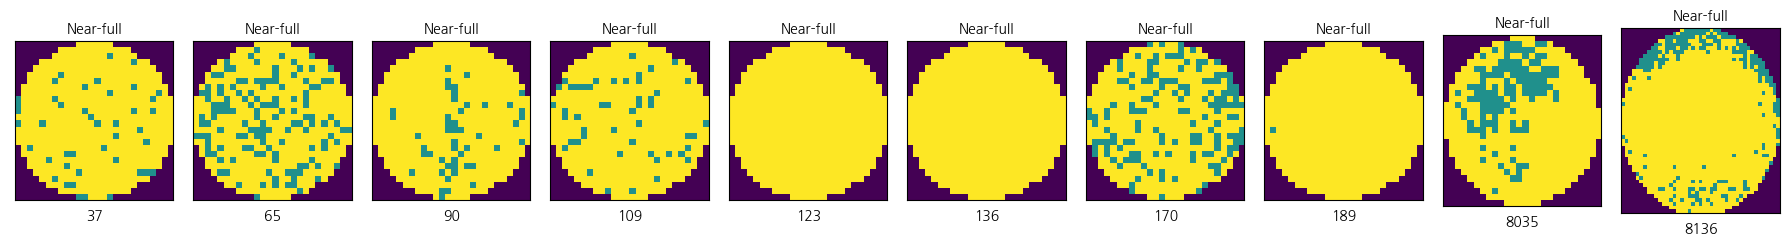

In [16]:
#불량 종류 시각화 - 3
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_label_values.waferMap[df_label_values.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_label_values.failureType[img.index[i]], fontsize=10)
            ax[i].set_xlabel(df_label_values.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

In [17]:
df_wafermap.groupby('failureType')['failureType'].count()

failureType
Center         4294
Donut           555
Edge-Loc       5189
Edge-Ring      9680
Loc            3593
Near-full       149
Random          866
Scratch        1193
none         147431
Name: failureType, dtype: int64

In [18]:
#모델 구조를 좀더 자세히 보기위한 커스텀 Fuction
def custom_summary(model):
    print("Model: {}".format(model.name))
    print("Layers:")
    
    input_shape = model.layers[0].input_shape
    for i, layer in enumerate(model.layers):
        config = layer.get_config()
        output_shape = layer.output_shape
        
        layer_info = "  Layer {}: {} |".format(i, layer.__class__.__name__)
        
        if 'filters' in config:
            layer_info += " Filters: {} |".format(config['filters'])
        if 'kernel_size' in config:
            layer_info += " Filter size: {}x{} |".format(config['kernel_size'][0], config['kernel_size'][1])
        if 'padding' in config:
            layer_info += " Padding: {} |".format(config['padding'])
        if 'activation' in config:
            layer_info += " Activation: {} |".format(config['activation'])
            
        if isinstance(output_shape, list):
            output_shape = output_shape[0]
        
        layer_info += " Output shape: {}".format(output_shape)
        print(layer_info)
        
        input_shape = output_shape

In [19]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="wafermap_train",

    # track hyperparameters and run metadata with wandb.config
    config={
        "learning_rate": 0.001,
        "epoch": 100,
        "batch_size": 100
    }
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hyunwoojang86 (euclidsoft). Use `wandb login --relogin` to force relogin


In [20]:
#전체 9가지 라벨 리스트
wf_train_labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full', 'none']
#논문에서 제안한 모델 파라미터를 그대로 적용함.
#논문에서는 224*224로 제언하였으나, VRAM 문제로 인하여 112*112로 줄여서 실험
model = Sequential([    
    # 이미지 처리 및 특징 추출 레이어    
    # Input
    Input(shape=(224, 224, 3)),
    
    # block 1
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),

    # block 2
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),

    # block 3
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),

    # block 4
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),  
    
    # block 5
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),    
    
    
    SpatialDropout2D(rate=0.2),
    
    Flatten(),
    
    # 레이어 완전연결 및 출력 레이어 설정
    Dense(4608, activation='relu'),    
    Dropout(0.5),
    Dense(512, activation='relu'),    
    Dropout(0.5),
    Dense(9, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=config.learning_rate)
              , loss='categorical_crossentropy'
              , metrics=['accuracy'
                         , tf.keras.metrics.Recall()
                         , tf.keras.metrics.Precision()
                        , tensorflow_addons.metrics.F1Score(num_classes=len(wf_train_labels), average='macro')
                        ])
custom_summary(model)

Model: sequential
Layers:
  Layer 0: Conv2D | Filters: 16 | Filter size: 3x3 | Padding: valid | Activation: relu | Output shape: (None, 222, 222, 16)
  Layer 1: BatchNormalization | Output shape: (None, 222, 222, 16)
  Layer 2: MaxPooling2D | Padding: valid | Output shape: (None, 111, 111, 16)
  Layer 3: Conv2D | Filters: 16 | Filter size: 3x3 | Padding: same | Activation: relu | Output shape: (None, 111, 111, 16)
  Layer 4: Conv2D | Filters: 32 | Filter size: 3x3 | Padding: same | Activation: relu | Output shape: (None, 111, 111, 32)
  Layer 5: BatchNormalization | Output shape: (None, 111, 111, 32)
  Layer 6: MaxPooling2D | Padding: valid | Output shape: (None, 55, 55, 32)
  Layer 7: Conv2D | Filters: 32 | Filter size: 3x3 | Padding: same | Activation: relu | Output shape: (None, 55, 55, 32)
  Layer 8: Conv2D | Filters: 64 | Filter size: 3x3 | Padding: same | Activation: relu | Output shape: (None, 55, 55, 64)
  Layer 9: BatchNormalization | Output shape: (None, 55, 55, 64)
  Layer 1

In [21]:
#불량 이미지 저장을 위한 폴더 생성
for f_labels in wf_train_labels:
    if not os.path.exists(os.path.join('wafermap_images', f_labels)):
        os.makedirs(os.path.join('wafermap_images', f_labels))

In [22]:
#이미지 추출 및 파일 저장 함수
def image_write(rows):
    write_path = os.path.join('wafermap_images', rows['failureType'], str(int(rows['index'])) + '.png')
    wafermap_rgb = np.zeros((rows['waferMap'].shape[0], rows['waferMap'].shape[1], 3), dtype=np.uint8)
    for i in range(rows['waferMap'].shape[0]):
        for j in range(rows['waferMap'].shape[1]):
            # wafermap의 각 값에 대한 RGB 색상 코드를 설정합니다.
            if rows['waferMap'][i, j] == 0:
                wafermap_rgb[i, j] = [82, 1, 74]  # 검정색 (배경)
            elif rows['waferMap'][i, j] == 1:
                wafermap_rgb[i, j] = [37, 231, 255]  # 노란색 (양품)
            else:
                wafermap_rgb[i, j] = [150, 144, 28]  # 초록색 (불량)
    cv2.cvtColor(wafermap_rgb, cv2.COLOR_BGR2RGB)
    cv2.imwrite(write_path, wafermap_rgb)

In [23]:
#이미지 추출 및 이미지 객체 리턴 함수
def image_return_wafermap(waferMap):
    wafermap_rgb = np.zeros((waferMap.shape[0], waferMap.shape[1], 3), dtype=np.uint8)
    for i in range(waferMap.shape[0]):
        for j in range(waferMap.shape[1]):
            # wafermap의 각 값에 대한 RGB 색상 코드를 설정합니다.
            if waferMap[i, j] == 0:
                wafermap_rgb[i, j] = [82, 1, 74]  # 검정색 (배경)
            elif waferMap[i, j] == 1:
                wafermap_rgb[i, j] = [37, 231, 255]  # 노란색 (양품)
            else:
                wafermap_rgb[i, j] = [150, 144, 28]  # 초록색 (불량)
    return wafermap_rgb

In [24]:
#최초 실행시 이미지 저장 실행(멀티 프로세싱 적용)
if is_first:
    df_wafermap.mapply(lambda x: image_write(x), axis=1)

In [25]:
#증량 작업을 위한 ImageDataGenerator 초기화
image_data_generator = ImageDataGenerator(
    rotation_range=10,           # 0~10°의 무작위 회전
    width_shift_range=0.2,       # 너비 이동 (0~1 사이의 비율)
    height_shift_range=0.2,      # 높이 이동 (0~1 사이의 비율)
    shear_range=0.15,             # 전단 변환 적용 범위 (0~1 사이의 비율)
    zoom_range=0.1,              # 확대/축소 범위 (1±zoom_range)
    horizontal_flip=True,        # 좌우 대칭 적용
    channel_shift_range=0.1,     # 채널 값 이동 범위 (0~1 사이의 비율)
    fill_mode='nearest'          # 이미지 외부 영역의 픽셀을 어떻게 채울지 결정 ('nearest', 'constant', 'reflect', 'wrap')
)

In [26]:
#증량 작업을 위한 코드
wf_labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
if is_first:
    for l in wf_labels:
        wafer_label_images = df_wafermap[df_wafermap['failureType'] == l]
        wafer_label_images = wafer_label_images.reset_index()
        aug_count = 10000 - len(wafer_label_images)
        print(l)
        for i in tqdm(range(aug_count)):
            random_idx = random.randint(0, len(wafer_label_images) - 1)
            wafer_image = image_return_wafermap(wafer_label_images.iloc[random_idx].waferMap)
            wafer_image = np.expand_dims(wafer_image, 0)
            g = image_data_generator.flow(wafer_image, batch_size=1)
            aug_image = next(g)
            write_path = os.path.join('wafermap_images', l, str(int(i)) + '_augmentation.png')
            if not os.path.exists(os.path.join('wafermap_images', l)):
                os.makedirs(os.path.join('wafermap_images', l))
            cv2.imwrite(write_path, aug_image[0])

In [27]:
none_size = 10000

In [28]:
#각 라벨링별 1만건 추출 작업
all_train_images = []
for idx, l in enumerate(wf_train_labels):
    image_directory = os.path.join('wafermap_images', l)
    ims = [(os.path.join(image_directory, f), idx) for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]
    random.shuffle(ims)
    if l == 'none':
        ims = ims[:none_size]
    all_train_images.extend(ims)

In [29]:
pd.DataFrame(all_train_images, columns=['image_path', 'failureType']).groupby('failureType').count()

,image_path
failureType,
0,10000
1,10000
2,10000
3,10000
4,10000
5,10000
6,10000
7,10000
8,10000


In [30]:
#train, val, test 데이터셋 추출(65 : 20 : 10)
train_files, test_files = train_test_split(all_train_images, test_size=0.35, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.42, random_state=42)

In [31]:
print('train_data : ', len(train_files)
      , '\nvalidation_data : ', len(val_files)
      , '\ntest_data : ', len(test_files))

train_data :  58500 
validation_data :  18270 
test_data :  13230


In [32]:
#모델 선언시 언급한 문제로 입력 사이즈 112*112에 따라 이미지 리사즈하여 로드 처리
dsize = 224
def load_images_and_labels(files_list):
    images, labels = [], []
    for file, label in tqdm(files_list):
        img = cv2.imread(file)
        img = cv2.resize(img, (dsize, dsize))
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

In [33]:
#학습 데이터 로드
train_images, train_labels = load_images_and_labels(train_files)
val_images, val_labels = load_images_and_labels(val_files)
test_images, test_labels = load_images_and_labels(test_files)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13230/13230 [00:00<00:00, 15415.11it/s]


In [34]:
#라벨링 데이터 차원 변경
train_labels = to_categorical(train_labels, len(wf_train_labels))
val_labels = to_categorical(val_labels, len(wf_train_labels))
test_labels = to_categorical(test_labels, len(wf_train_labels))

In [35]:
with tf.device('CPU'):
    #데이터 메모리 선 적재를 위한 텐서 변경 및 분할 작업
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

2023-04-20 22:40:55.606137: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8805888000 exceeds 10% of free system memory.


In [36]:
batch_size = 100  #배치크기
buffer_size = 10000  # 버퍼크기
epochs = 100 #에폭
steps_per_epoch = len(train_images) // batch_size  # steps_per_epoch 계산
val_steps_per_epoch = len(val_images) // batch_size  # val_steps_per_epoch 계산

In [37]:
# 학습 데이터를 섞어 미리 메모리 적재(빠른 로딩을 위한 동적로드 적용)
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)

In [38]:
# 검증 데이터를 섞어 미리 메모리 적재(빠른 로딩을 위한 동적로드 적용)
validation_dataset = validation_dataset.shuffle(buffer_size).batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)

In [39]:
#학습 진행
model_fit_history = None
model_fit_history = model.fit(train_dataset
                              , validation_data=validation_dataset
                              , validation_steps=val_steps_per_epoch
                              , epochs=epochs
                              , steps_per_epoch=steps_per_epoch
                             , callbacks=[WandbMetricsLogger(log_freq=5),
                                      WandbModelCheckpoint("models")
                                    ])

2023-04-20 22:40:57.915995: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8805888000 exceeds 10% of free system memory.


Epoch 1/100
585/585 [==============================] - ETA: 0s - loss: 1.0171 - accuracy: 0.6880 - recall: 0.5788 - precision: 0.8039 - f1_score: 0.6810

2023-04-20 22:41:45.745148: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2750146560 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 52s 84ms/step - loss: 1.0171 - accuracy: 0.6880 - recall: 0.5788 - precision: 0.8039 - f1_score: 0.6810 - val_loss: 0.6451 - val_accuracy: 0.7750 - val_recall: 0.7140 - val_precision: 0.8324 - val_f1_score: 0.7647
Epoch 2/100
585/585 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.8027 - recall: 0.7363 - precision: 0.8624 - f1_score: 0.7991

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 82ms/step - loss: 0.5643 - accuracy: 0.8027 - recall: 0.7363 - precision: 0.8624 - f1_score: 0.7991 - val_loss: 0.4494 - val_accuracy: 0.8400 - val_recall: 0.7871 - val_precision: 0.8871 - val_f1_score: 0.8334
Epoch 3/100
585/585 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.8425 - recall: 0.7994 - precision: 0.8847 - f1_score: 0.8402

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.4554 - accuracy: 0.8425 - recall: 0.7994 - precision: 0.8847 - f1_score: 0.8402 - val_loss: 0.4789 - val_accuracy: 0.8385 - val_recall: 0.7915 - val_precision: 0.8830 - val_f1_score: 0.8417
Epoch 4/100
585/585 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.8700 - recall: 0.8360 - precision: 0.9011 - f1_score: 0.8684

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 82ms/step - loss: 0.3826 - accuracy: 0.8700 - recall: 0.8360 - precision: 0.9011 - f1_score: 0.8684 - val_loss: 1.6556 - val_accuracy: 0.7083 - val_recall: 0.6740 - val_precision: 0.7321 - val_f1_score: 0.7229
Epoch 5/100
585/585 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8831 - recall: 0.8554 - precision: 0.9108 - f1_score: 0.8820

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.3449 - accuracy: 0.8831 - recall: 0.8554 - precision: 0.9108 - f1_score: 0.8820 - val_loss: 0.4083 - val_accuracy: 0.8626 - val_recall: 0.8326 - val_precision: 0.8930 - val_f1_score: 0.8607
Epoch 6/100
585/585 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8938 - recall: 0.8706 - precision: 0.9164 - f1_score: 0.8929

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.3082 - accuracy: 0.8938 - recall: 0.8706 - precision: 0.9164 - f1_score: 0.8929 - val_loss: 0.3165 - val_accuracy: 0.8853 - val_recall: 0.8671 - val_precision: 0.9062 - val_f1_score: 0.8827
Epoch 7/100
585/585 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.9054 - recall: 0.8857 - precision: 0.9245 - f1_score: 0.9048

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 82ms/step - loss: 0.2749 - accuracy: 0.9054 - recall: 0.8857 - precision: 0.9245 - f1_score: 0.9048 - val_loss: 0.3043 - val_accuracy: 0.8924 - val_recall: 0.8716 - val_precision: 0.9129 - val_f1_score: 0.8914
Epoch 8/100
585/585 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9155 - recall: 0.9001 - precision: 0.9322 - f1_score: 0.9150

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.2472 - accuracy: 0.9155 - recall: 0.9001 - precision: 0.9322 - f1_score: 0.9150 - val_loss: 0.2577 - val_accuracy: 0.9122 - val_recall: 0.8954 - val_precision: 0.9282 - val_f1_score: 0.9103
Epoch 9/100
585/585 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9246 - recall: 0.9107 - precision: 0.9378 - f1_score: 0.9243

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.2243 - accuracy: 0.9246 - recall: 0.9107 - precision: 0.9378 - f1_score: 0.9243 - val_loss: 0.2844 - val_accuracy: 0.9041 - val_recall: 0.8884 - val_precision: 0.9215 - val_f1_score: 0.9036
Epoch 10/100
585/585 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9344 - recall: 0.9236 - precision: 0.9451 - f1_score: 0.9341

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.1911 - accuracy: 0.9344 - recall: 0.9236 - precision: 0.9451 - f1_score: 0.9341 - val_loss: 0.3266 - val_accuracy: 0.8927 - val_recall: 0.8787 - val_precision: 0.9092 - val_f1_score: 0.8917
Epoch 11/100
585/585 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9411 - recall: 0.9321 - precision: 0.9497 - f1_score: 0.9410

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 82ms/step - loss: 0.1752 - accuracy: 0.9411 - recall: 0.9321 - precision: 0.9497 - f1_score: 0.9410 - val_loss: 0.3484 - val_accuracy: 0.8843 - val_recall: 0.8612 - val_precision: 0.9087 - val_f1_score: 0.8840
Epoch 12/100
585/585 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9373 - recall: 0.9295 - precision: 0.9472 - f1_score: 0.9371

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.1915 - accuracy: 0.9373 - recall: 0.9295 - precision: 0.9472 - f1_score: 0.9371 - val_loss: 0.3749 - val_accuracy: 0.8921 - val_recall: 0.8789 - val_precision: 0.9059 - val_f1_score: 0.8907
Epoch 13/100
585/585 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9425 - recall: 0.9343 - precision: 0.9510 - f1_score: 0.9424

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.1740 - accuracy: 0.9425 - recall: 0.9343 - precision: 0.9510 - f1_score: 0.9424 - val_loss: 0.2751 - val_accuracy: 0.9142 - val_recall: 0.9069 - val_precision: 0.9229 - val_f1_score: 0.9139
Epoch 14/100
585/585 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9568 - recall: 0.9518 - precision: 0.9624 - f1_score: 0.9568

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.1276 - accuracy: 0.9568 - recall: 0.9518 - precision: 0.9624 - f1_score: 0.9568 - val_loss: 0.3135 - val_accuracy: 0.9172 - val_recall: 0.9120 - val_precision: 0.9253 - val_f1_score: 0.9166
Epoch 15/100
585/585 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9608 - recall: 0.9568 - precision: 0.9654 - f1_score: 0.9608

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.1172 - accuracy: 0.9608 - recall: 0.9568 - precision: 0.9654 - f1_score: 0.9608 - val_loss: 0.3033 - val_accuracy: 0.9179 - val_recall: 0.9128 - val_precision: 0.9239 - val_f1_score: 0.9165
Epoch 16/100
585/585 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9607 - recall: 0.9565 - precision: 0.9650 - f1_score: 0.9607

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 82ms/step - loss: 0.1212 - accuracy: 0.9607 - recall: 0.9565 - precision: 0.9650 - f1_score: 0.9607 - val_loss: 0.3061 - val_accuracy: 0.9093 - val_recall: 0.8993 - val_precision: 0.9215 - val_f1_score: 0.9084
Epoch 17/100
585/585 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9682 - recall: 0.9653 - precision: 0.9715 - f1_score: 0.9682

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 82ms/step - loss: 0.0966 - accuracy: 0.9682 - recall: 0.9653 - precision: 0.9715 - f1_score: 0.9682 - val_loss: 0.2883 - val_accuracy: 0.9175 - val_recall: 0.9118 - val_precision: 0.9247 - val_f1_score: 0.9168
Epoch 18/100
585/585 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9695 - recall: 0.9669 - precision: 0.9725 - f1_score: 0.9695

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0921 - accuracy: 0.9695 - recall: 0.9669 - precision: 0.9725 - f1_score: 0.9695 - val_loss: 0.3325 - val_accuracy: 0.9150 - val_recall: 0.9101 - val_precision: 0.9221 - val_f1_score: 0.9142
Epoch 19/100
585/585 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9731 - recall: 0.9706 - precision: 0.9755 - f1_score: 0.9731

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0830 - accuracy: 0.9731 - recall: 0.9706 - precision: 0.9755 - f1_score: 0.9731 - val_loss: 0.3434 - val_accuracy: 0.9171 - val_recall: 0.9138 - val_precision: 0.9216 - val_f1_score: 0.9167
Epoch 20/100
585/585 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9666 - recall: 0.9635 - precision: 0.9698 - f1_score: 0.9666

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 82ms/step - loss: 0.1150 - accuracy: 0.9666 - recall: 0.9635 - precision: 0.9698 - f1_score: 0.9666 - val_loss: 0.3937 - val_accuracy: 0.9086 - val_recall: 0.9047 - val_precision: 0.9129 - val_f1_score: 0.9086
Epoch 21/100
585/585 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9772 - recall: 0.9754 - precision: 0.9788 - f1_score: 0.9772

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0750 - accuracy: 0.9772 - recall: 0.9754 - precision: 0.9788 - f1_score: 0.9772 - val_loss: 0.3374 - val_accuracy: 0.9098 - val_recall: 0.9057 - val_precision: 0.9159 - val_f1_score: 0.9097
Epoch 22/100
585/585 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9771 - recall: 0.9757 - precision: 0.9789 - f1_score: 0.9771

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0721 - accuracy: 0.9771 - recall: 0.9757 - precision: 0.9789 - f1_score: 0.9771 - val_loss: 0.3128 - val_accuracy: 0.9143 - val_recall: 0.9081 - val_precision: 0.9230 - val_f1_score: 0.9130
Epoch 23/100
585/585 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9795 - recall: 0.9780 - precision: 0.9810 - f1_score: 0.9795

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0668 - accuracy: 0.9795 - recall: 0.9780 - precision: 0.9810 - f1_score: 0.9795 - val_loss: 0.3802 - val_accuracy: 0.9156 - val_recall: 0.9122 - val_precision: 0.9210 - val_f1_score: 0.9138
Epoch 24/100
585/585 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9780 - recall: 0.9761 - precision: 0.9797 - f1_score: 0.9780

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0755 - accuracy: 0.9780 - recall: 0.9761 - precision: 0.9797 - f1_score: 0.9780 - val_loss: 0.3626 - val_accuracy: 0.9160 - val_recall: 0.9138 - val_precision: 0.9200 - val_f1_score: 0.9154
Epoch 25/100
585/585 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9802 - recall: 0.9788 - precision: 0.9814 - f1_score: 0.9802

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0657 - accuracy: 0.9802 - recall: 0.9788 - precision: 0.9814 - f1_score: 0.9802 - val_loss: 0.3811 - val_accuracy: 0.9131 - val_recall: 0.9091 - val_precision: 0.9184 - val_f1_score: 0.9133
Epoch 26/100
585/585 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9818 - recall: 0.9805 - precision: 0.9831 - f1_score: 0.9818

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0605 - accuracy: 0.9818 - recall: 0.9805 - precision: 0.9831 - f1_score: 0.9818 - val_loss: 0.3956 - val_accuracy: 0.9119 - val_recall: 0.9085 - val_precision: 0.9160 - val_f1_score: 0.9122
Epoch 27/100
585/585 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9830 - recall: 0.9819 - precision: 0.9843 - f1_score: 0.9830

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0575 - accuracy: 0.9830 - recall: 0.9819 - precision: 0.9843 - f1_score: 0.9830 - val_loss: 0.5469 - val_accuracy: 0.9105 - val_recall: 0.9086 - val_precision: 0.9135 - val_f1_score: 0.9083
Epoch 28/100
585/585 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9832 - recall: 0.9823 - precision: 0.9840 - f1_score: 0.9832

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 84ms/step - loss: 0.0549 - accuracy: 0.9832 - recall: 0.9823 - precision: 0.9840 - f1_score: 0.9832 - val_loss: 0.4184 - val_accuracy: 0.9127 - val_recall: 0.9088 - val_precision: 0.9163 - val_f1_score: 0.9118
Epoch 29/100
585/585 [==============================] - ETA: 0s - loss: 0.0561 - accuracy: 0.9832 - recall: 0.9822 - precision: 0.9844 - f1_score: 0.9832

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0561 - accuracy: 0.9832 - recall: 0.9822 - precision: 0.9844 - f1_score: 0.9832 - val_loss: 0.3860 - val_accuracy: 0.9173 - val_recall: 0.9147 - val_precision: 0.9211 - val_f1_score: 0.9172
Epoch 30/100
585/585 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9843 - recall: 0.9834 - precision: 0.9853 - f1_score: 0.9843

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0527 - accuracy: 0.9843 - recall: 0.9834 - precision: 0.9853 - f1_score: 0.9843 - val_loss: 0.4327 - val_accuracy: 0.9109 - val_recall: 0.9082 - val_precision: 0.9157 - val_f1_score: 0.9090
Epoch 31/100
585/585 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9842 - recall: 0.9834 - precision: 0.9852 - f1_score: 0.9842

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0514 - accuracy: 0.9842 - recall: 0.9834 - precision: 0.9852 - f1_score: 0.9842 - val_loss: 0.3715 - val_accuracy: 0.9158 - val_recall: 0.9115 - val_precision: 0.9206 - val_f1_score: 0.9152
Epoch 32/100
585/585 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9855 - recall: 0.9848 - precision: 0.9863 - f1_score: 0.9856

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0497 - accuracy: 0.9855 - recall: 0.9848 - precision: 0.9863 - f1_score: 0.9856 - val_loss: 0.4029 - val_accuracy: 0.9115 - val_recall: 0.9064 - val_precision: 0.9177 - val_f1_score: 0.9099
Epoch 33/100
585/585 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9856 - recall: 0.9847 - precision: 0.9866 - f1_score: 0.9856

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0494 - accuracy: 0.9856 - recall: 0.9847 - precision: 0.9866 - f1_score: 0.9856 - val_loss: 0.3756 - val_accuracy: 0.9147 - val_recall: 0.9113 - val_precision: 0.9190 - val_f1_score: 0.9138
Epoch 34/100
585/585 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9856 - recall: 0.9849 - precision: 0.9864 - f1_score: 0.9856

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0500 - accuracy: 0.9856 - recall: 0.9849 - precision: 0.9864 - f1_score: 0.9856 - val_loss: 0.4160 - val_accuracy: 0.9162 - val_recall: 0.9130 - val_precision: 0.9204 - val_f1_score: 0.9146
Epoch 35/100
585/585 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9880 - recall: 0.9874 - precision: 0.9888 - f1_score: 0.9880

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 82ms/step - loss: 0.0410 - accuracy: 0.9880 - recall: 0.9874 - precision: 0.9888 - f1_score: 0.9880 - val_loss: 0.4285 - val_accuracy: 0.9137 - val_recall: 0.9099 - val_precision: 0.9183 - val_f1_score: 0.9123
Epoch 36/100
585/585 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9888 - recall: 0.9883 - precision: 0.9895 - f1_score: 0.9888

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0372 - accuracy: 0.9888 - recall: 0.9883 - precision: 0.9895 - f1_score: 0.9888 - val_loss: 0.4289 - val_accuracy: 0.9216 - val_recall: 0.9197 - val_precision: 0.9250 - val_f1_score: 0.9208
Epoch 37/100
585/585 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9869 - recall: 0.9862 - precision: 0.9877 - f1_score: 0.9869

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0467 - accuracy: 0.9869 - recall: 0.9862 - precision: 0.9877 - f1_score: 0.9869 - val_loss: 0.4490 - val_accuracy: 0.9123 - val_recall: 0.9097 - val_precision: 0.9167 - val_f1_score: 0.9100
Epoch 38/100
585/585 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9875 - recall: 0.9866 - precision: 0.9882 - f1_score: 0.9875

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0444 - accuracy: 0.9875 - recall: 0.9866 - precision: 0.9882 - f1_score: 0.9875 - val_loss: 0.4641 - val_accuracy: 0.9114 - val_recall: 0.9084 - val_precision: 0.9157 - val_f1_score: 0.9111
Epoch 39/100
585/585 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9869 - recall: 0.9862 - precision: 0.9876 - f1_score: 0.9869

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0445 - accuracy: 0.9869 - recall: 0.9862 - precision: 0.9876 - f1_score: 0.9869 - val_loss: 0.4614 - val_accuracy: 0.9127 - val_recall: 0.9101 - val_precision: 0.9162 - val_f1_score: 0.9109
Epoch 40/100
585/585 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9887 - recall: 0.9880 - precision: 0.9894 - f1_score: 0.9887

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0381 - accuracy: 0.9887 - recall: 0.9880 - precision: 0.9894 - f1_score: 0.9887 - val_loss: 0.4684 - val_accuracy: 0.9159 - val_recall: 0.9131 - val_precision: 0.9200 - val_f1_score: 0.9142
Epoch 41/100
585/585 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9889 - recall: 0.9884 - precision: 0.9894 - f1_score: 0.9889

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 82ms/step - loss: 0.0399 - accuracy: 0.9889 - recall: 0.9884 - precision: 0.9894 - f1_score: 0.9889 - val_loss: 0.4647 - val_accuracy: 0.9084 - val_recall: 0.9062 - val_precision: 0.9124 - val_f1_score: 0.9074
Epoch 42/100
585/585 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9872 - recall: 0.9866 - precision: 0.9878 - f1_score: 0.9872

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 82ms/step - loss: 0.0453 - accuracy: 0.9872 - recall: 0.9866 - precision: 0.9878 - f1_score: 0.9872 - val_loss: 0.4612 - val_accuracy: 0.9072 - val_recall: 0.9038 - val_precision: 0.9129 - val_f1_score: 0.9053
Epoch 43/100
585/585 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9898 - recall: 0.9892 - precision: 0.9904 - f1_score: 0.9899

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0362 - accuracy: 0.9898 - recall: 0.9892 - precision: 0.9904 - f1_score: 0.9899 - val_loss: 0.4245 - val_accuracy: 0.9149 - val_recall: 0.9099 - val_precision: 0.9202 - val_f1_score: 0.9126
Epoch 44/100
585/585 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9890 - recall: 0.9886 - precision: 0.9896 - f1_score: 0.9890

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0371 - accuracy: 0.9890 - recall: 0.9886 - precision: 0.9896 - f1_score: 0.9890 - val_loss: 0.4174 - val_accuracy: 0.9168 - val_recall: 0.9128 - val_precision: 0.9213 - val_f1_score: 0.9166
Epoch 45/100
585/585 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9906 - recall: 0.9902 - precision: 0.9911 - f1_score: 0.9906

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0328 - accuracy: 0.9906 - recall: 0.9902 - precision: 0.9911 - f1_score: 0.9906 - val_loss: 0.3917 - val_accuracy: 0.9226 - val_recall: 0.9199 - val_precision: 0.9269 - val_f1_score: 0.9221
Epoch 46/100
585/585 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9888 - recall: 0.9883 - precision: 0.9891 - f1_score: 0.9888

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 84ms/step - loss: 0.0436 - accuracy: 0.9888 - recall: 0.9883 - precision: 0.9891 - f1_score: 0.9888 - val_loss: 0.5308 - val_accuracy: 0.9139 - val_recall: 0.9114 - val_precision: 0.9178 - val_f1_score: 0.9114
Epoch 47/100
585/585 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9891 - recall: 0.9884 - precision: 0.9895 - f1_score: 0.9891

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0394 - accuracy: 0.9891 - recall: 0.9884 - precision: 0.9895 - f1_score: 0.9891 - val_loss: 0.4336 - val_accuracy: 0.9232 - val_recall: 0.9205 - val_precision: 0.9269 - val_f1_score: 0.9221
Epoch 48/100
585/585 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9897 - recall: 0.9891 - precision: 0.9903 - f1_score: 0.9897

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0362 - accuracy: 0.9897 - recall: 0.9891 - precision: 0.9903 - f1_score: 0.9897 - val_loss: 0.4089 - val_accuracy: 0.9202 - val_recall: 0.9175 - val_precision: 0.9259 - val_f1_score: 0.9190
Epoch 49/100
585/585 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9900 - recall: 0.9894 - precision: 0.9907 - f1_score: 0.9900

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0376 - accuracy: 0.9900 - recall: 0.9894 - precision: 0.9907 - f1_score: 0.9900 - val_loss: 0.4409 - val_accuracy: 0.9206 - val_recall: 0.9176 - val_precision: 0.9249 - val_f1_score: 0.9194
Epoch 50/100
585/585 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9912 - recall: 0.9909 - precision: 0.9917 - f1_score: 0.9912

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0324 - accuracy: 0.9912 - recall: 0.9909 - precision: 0.9917 - f1_score: 0.9912 - val_loss: 0.4279 - val_accuracy: 0.9171 - val_recall: 0.9130 - val_precision: 0.9222 - val_f1_score: 0.9155
Epoch 51/100
585/585 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9911 - recall: 0.9909 - precision: 0.9916 - f1_score: 0.9912

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 82ms/step - loss: 0.0311 - accuracy: 0.9911 - recall: 0.9909 - precision: 0.9916 - f1_score: 0.9912 - val_loss: 0.5711 - val_accuracy: 0.9148 - val_recall: 0.9129 - val_precision: 0.9177 - val_f1_score: 0.9131
Epoch 52/100
585/585 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 0.9904 - recall: 0.9899 - precision: 0.9907 - f1_score: 0.9904

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0355 - accuracy: 0.9904 - recall: 0.9899 - precision: 0.9907 - f1_score: 0.9904 - val_loss: 0.4906 - val_accuracy: 0.9154 - val_recall: 0.9124 - val_precision: 0.9191 - val_f1_score: 0.9142
Epoch 53/100
585/585 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9882 - recall: 0.9877 - precision: 0.9888 - f1_score: 0.9882

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0482 - accuracy: 0.9882 - recall: 0.9877 - precision: 0.9888 - f1_score: 0.9882 - val_loss: 0.5841 - val_accuracy: 0.9076 - val_recall: 0.9037 - val_precision: 0.9132 - val_f1_score: 0.9064
Epoch 54/100
585/585 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9902 - recall: 0.9897 - precision: 0.9905 - f1_score: 0.9902

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 82ms/step - loss: 0.0382 - accuracy: 0.9902 - recall: 0.9897 - precision: 0.9905 - f1_score: 0.9902 - val_loss: 0.4696 - val_accuracy: 0.9146 - val_recall: 0.9116 - val_precision: 0.9191 - val_f1_score: 0.9134
Epoch 55/100
585/585 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9915 - recall: 0.9911 - precision: 0.9919 - f1_score: 0.9915

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0298 - accuracy: 0.9915 - recall: 0.9911 - precision: 0.9919 - f1_score: 0.9915 - val_loss: 0.4829 - val_accuracy: 0.9212 - val_recall: 0.9188 - val_precision: 0.9248 - val_f1_score: 0.9198
Epoch 56/100
585/585 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9913 - recall: 0.9909 - precision: 0.9915 - f1_score: 0.9913

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0315 - accuracy: 0.9913 - recall: 0.9909 - precision: 0.9915 - f1_score: 0.9913 - val_loss: 0.4650 - val_accuracy: 0.9217 - val_recall: 0.9197 - val_precision: 0.9254 - val_f1_score: 0.9206
Epoch 57/100
585/585 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9902 - recall: 0.9898 - precision: 0.9908 - f1_score: 0.9902

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0353 - accuracy: 0.9902 - recall: 0.9898 - precision: 0.9908 - f1_score: 0.9902 - val_loss: 0.5343 - val_accuracy: 0.9170 - val_recall: 0.9151 - val_precision: 0.9207 - val_f1_score: 0.9158
Epoch 58/100
585/585 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9910 - recall: 0.9906 - precision: 0.9915 - f1_score: 0.9910

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0329 - accuracy: 0.9910 - recall: 0.9906 - precision: 0.9915 - f1_score: 0.9910 - val_loss: 0.6285 - val_accuracy: 0.9062 - val_recall: 0.9044 - val_precision: 0.9095 - val_f1_score: 0.9037
Epoch 59/100
585/585 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9916 - recall: 0.9914 - precision: 0.9919 - f1_score: 0.9916

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0320 - accuracy: 0.9916 - recall: 0.9914 - precision: 0.9919 - f1_score: 0.9916 - val_loss: 0.4419 - val_accuracy: 0.9220 - val_recall: 0.9197 - val_precision: 0.9255 - val_f1_score: 0.9210
Epoch 60/100
585/585 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9912 - recall: 0.9909 - precision: 0.9917 - f1_score: 0.9912

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0343 - accuracy: 0.9912 - recall: 0.9909 - precision: 0.9917 - f1_score: 0.9912 - val_loss: 0.6934 - val_accuracy: 0.8509 - val_recall: 0.8412 - val_precision: 0.8626 - val_f1_score: 0.8535
Epoch 61/100
585/585 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9897 - recall: 0.9893 - precision: 0.9905 - f1_score: 0.9897

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0398 - accuracy: 0.9897 - recall: 0.9893 - precision: 0.9905 - f1_score: 0.9897 - val_loss: 0.6797 - val_accuracy: 0.9036 - val_recall: 0.9006 - val_precision: 0.9071 - val_f1_score: 0.8999
Epoch 62/100
585/585 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9918 - recall: 0.9915 - precision: 0.9923 - f1_score: 0.9918

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0294 - accuracy: 0.9918 - recall: 0.9915 - precision: 0.9923 - f1_score: 0.9918 - val_loss: 0.4934 - val_accuracy: 0.9133 - val_recall: 0.9094 - val_precision: 0.9198 - val_f1_score: 0.9111
Epoch 63/100
585/585 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9912 - recall: 0.9909 - precision: 0.9915 - f1_score: 0.9912

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0319 - accuracy: 0.9912 - recall: 0.9909 - precision: 0.9915 - f1_score: 0.9912 - val_loss: 0.5516 - val_accuracy: 0.9203 - val_recall: 0.9187 - val_precision: 0.9230 - val_f1_score: 0.9186
Epoch 64/100
585/585 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9899 - recall: 0.9894 - precision: 0.9906 - f1_score: 0.9899

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0581 - accuracy: 0.9899 - recall: 0.9894 - precision: 0.9906 - f1_score: 0.9899 - val_loss: 3.0648 - val_accuracy: 0.7108 - val_recall: 0.6949 - val_precision: 0.7307 - val_f1_score: 0.7169
Epoch 65/100
585/585 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9865 - recall: 0.9859 - precision: 0.9873 - f1_score: 0.9865

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0549 - accuracy: 0.9865 - recall: 0.9859 - precision: 0.9873 - f1_score: 0.9865 - val_loss: 0.5395 - val_accuracy: 0.9162 - val_recall: 0.9127 - val_precision: 0.9203 - val_f1_score: 0.9138
Epoch 66/100
585/585 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9906 - recall: 0.9900 - precision: 0.9912 - f1_score: 0.9906

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0393 - accuracy: 0.9906 - recall: 0.9900 - precision: 0.9912 - f1_score: 0.9906 - val_loss: 0.4681 - val_accuracy: 0.9219 - val_recall: 0.9195 - val_precision: 0.9259 - val_f1_score: 0.9209
Epoch 67/100
585/585 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9925 - recall: 0.9922 - precision: 0.9929 - f1_score: 0.9925

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.8s


585/585 [==============================] - 56s 95ms/step - loss: 0.0276 - accuracy: 0.9925 - recall: 0.9922 - precision: 0.9929 - f1_score: 0.9925 - val_loss: 0.5829 - val_accuracy: 0.9166 - val_recall: 0.9147 - val_precision: 0.9192 - val_f1_score: 0.9151
Epoch 68/100
585/585 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9927 - recall: 0.9925 - precision: 0.9930 - f1_score: 0.9927

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 50s 86ms/step - loss: 0.0252 - accuracy: 0.9927 - recall: 0.9925 - precision: 0.9930 - f1_score: 0.9927 - val_loss: 0.5755 - val_accuracy: 0.9156 - val_recall: 0.9137 - val_precision: 0.9189 - val_f1_score: 0.9136
Epoch 69/100
585/585 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9927 - recall: 0.9924 - precision: 0.9929 - f1_score: 0.9927

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0274 - accuracy: 0.9927 - recall: 0.9924 - precision: 0.9929 - f1_score: 0.9927 - val_loss: 0.5318 - val_accuracy: 0.9216 - val_recall: 0.9193 - val_precision: 0.9250 - val_f1_score: 0.9206
Epoch 70/100
585/585 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9905 - recall: 0.9900 - precision: 0.9909 - f1_score: 0.9905

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0392 - accuracy: 0.9905 - recall: 0.9900 - precision: 0.9909 - f1_score: 0.9905 - val_loss: 0.5491 - val_accuracy: 0.9195 - val_recall: 0.9173 - val_precision: 0.9234 - val_f1_score: 0.9180
Epoch 71/100
585/585 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9925 - recall: 0.9921 - precision: 0.9927 - f1_score: 0.9925

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0296 - accuracy: 0.9925 - recall: 0.9921 - precision: 0.9927 - f1_score: 0.9925 - val_loss: 0.4997 - val_accuracy: 0.9195 - val_recall: 0.9164 - val_precision: 0.9239 - val_f1_score: 0.9181
Epoch 72/100
585/585 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9927 - recall: 0.9925 - precision: 0.9931 - f1_score: 0.9927

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 82ms/step - loss: 0.0287 - accuracy: 0.9927 - recall: 0.9925 - precision: 0.9931 - f1_score: 0.9927 - val_loss: 0.4441 - val_accuracy: 0.9222 - val_recall: 0.9187 - val_precision: 0.9268 - val_f1_score: 0.9218
Epoch 73/100
585/585 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9928 - recall: 0.9926 - precision: 0.9930 - f1_score: 0.9928

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0282 - accuracy: 0.9928 - recall: 0.9926 - precision: 0.9930 - f1_score: 0.9928 - val_loss: 0.5903 - val_accuracy: 0.9150 - val_recall: 0.9120 - val_precision: 0.9193 - val_f1_score: 0.9123
Epoch 74/100
585/585 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9932 - recall: 0.9930 - precision: 0.9935 - f1_score: 0.9932

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.8s


585/585 [==============================] - 55s 93ms/step - loss: 0.0277 - accuracy: 0.9932 - recall: 0.9930 - precision: 0.9935 - f1_score: 0.9932 - val_loss: 0.5243 - val_accuracy: 0.9209 - val_recall: 0.9184 - val_precision: 0.9239 - val_f1_score: 0.9202
Epoch 75/100
585/585 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9926 - recall: 0.9922 - precision: 0.9929 - f1_score: 0.9926

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 52s 89ms/step - loss: 0.0269 - accuracy: 0.9926 - recall: 0.9922 - precision: 0.9929 - f1_score: 0.9926 - val_loss: 0.6861 - val_accuracy: 0.9218 - val_recall: 0.9207 - val_precision: 0.9240 - val_f1_score: 0.9209
Epoch 76/100
585/585 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9922 - recall: 0.9919 - precision: 0.9925 - f1_score: 0.9922

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0309 - accuracy: 0.9922 - recall: 0.9919 - precision: 0.9925 - f1_score: 0.9922 - val_loss: 0.5500 - val_accuracy: 0.9170 - val_recall: 0.9140 - val_precision: 0.9219 - val_f1_score: 0.9143
Epoch 77/100
585/585 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9934 - recall: 0.9931 - precision: 0.9936 - f1_score: 0.9934

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0244 - accuracy: 0.9934 - recall: 0.9931 - precision: 0.9936 - f1_score: 0.9934 - val_loss: 0.5558 - val_accuracy: 0.9184 - val_recall: 0.9159 - val_precision: 0.9214 - val_f1_score: 0.9163
Epoch 78/100
585/585 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9906 - recall: 0.9903 - precision: 0.9911 - f1_score: 0.9906

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0380 - accuracy: 0.9906 - recall: 0.9903 - precision: 0.9911 - f1_score: 0.9906 - val_loss: 0.6188 - val_accuracy: 0.9127 - val_recall: 0.9101 - val_precision: 0.9159 - val_f1_score: 0.9115
Epoch 79/100
585/585 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9920 - recall: 0.9917 - precision: 0.9922 - f1_score: 0.9920

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0318 - accuracy: 0.9920 - recall: 0.9917 - precision: 0.9922 - f1_score: 0.9920 - val_loss: 0.6113 - val_accuracy: 0.9144 - val_recall: 0.9120 - val_precision: 0.9178 - val_f1_score: 0.9118
Epoch 80/100
585/585 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9930 - recall: 0.9928 - precision: 0.9933 - f1_score: 0.9930

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0274 - accuracy: 0.9930 - recall: 0.9928 - precision: 0.9933 - f1_score: 0.9930 - val_loss: 0.5960 - val_accuracy: 0.9180 - val_recall: 0.9160 - val_precision: 0.9215 - val_f1_score: 0.9161
Epoch 81/100
585/585 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9936 - recall: 0.9934 - precision: 0.9939 - f1_score: 0.9936

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0271 - accuracy: 0.9936 - recall: 0.9934 - precision: 0.9939 - f1_score: 0.9936 - val_loss: 0.5410 - val_accuracy: 0.9168 - val_recall: 0.9143 - val_precision: 0.9213 - val_f1_score: 0.9149
Epoch 82/100
585/585 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9933 - recall: 0.9931 - precision: 0.9937 - f1_score: 0.9933

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0273 - accuracy: 0.9933 - recall: 0.9931 - precision: 0.9937 - f1_score: 0.9933 - val_loss: 0.5212 - val_accuracy: 0.9135 - val_recall: 0.9109 - val_precision: 0.9175 - val_f1_score: 0.9140
Epoch 83/100
585/585 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9927 - recall: 0.9923 - precision: 0.9930 - f1_score: 0.9927

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0296 - accuracy: 0.9927 - recall: 0.9923 - precision: 0.9930 - f1_score: 0.9927 - val_loss: 0.6828 - val_accuracy: 0.9115 - val_recall: 0.9097 - val_precision: 0.9147 - val_f1_score: 0.9092
Epoch 84/100
585/585 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9921 - recall: 0.9918 - precision: 0.9925 - f1_score: 0.9921

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0296 - accuracy: 0.9921 - recall: 0.9918 - precision: 0.9925 - f1_score: 0.9921 - val_loss: 0.6873 - val_accuracy: 0.9178 - val_recall: 0.9164 - val_precision: 0.9200 - val_f1_score: 0.9177
Epoch 85/100
585/585 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9926 - recall: 0.9922 - precision: 0.9930 - f1_score: 0.9926

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0300 - accuracy: 0.9926 - recall: 0.9922 - precision: 0.9930 - f1_score: 0.9926 - val_loss: 0.6201 - val_accuracy: 0.9039 - val_recall: 0.8997 - val_precision: 0.9088 - val_f1_score: 0.9000
Epoch 86/100
585/585 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9932 - recall: 0.9929 - precision: 0.9935 - f1_score: 0.9932

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0288 - accuracy: 0.9932 - recall: 0.9929 - precision: 0.9935 - f1_score: 0.9932 - val_loss: 0.5367 - val_accuracy: 0.9164 - val_recall: 0.9133 - val_precision: 0.9208 - val_f1_score: 0.9153
Epoch 87/100
585/585 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9931 - recall: 0.9929 - precision: 0.9935 - f1_score: 0.9931

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0292 - accuracy: 0.9931 - recall: 0.9929 - precision: 0.9935 - f1_score: 0.9931 - val_loss: 0.6583 - val_accuracy: 0.9192 - val_recall: 0.9174 - val_precision: 0.9215 - val_f1_score: 0.9179
Epoch 88/100
585/585 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9926 - recall: 0.9924 - precision: 0.9930 - f1_score: 0.9926

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0304 - accuracy: 0.9926 - recall: 0.9924 - precision: 0.9930 - f1_score: 0.9926 - val_loss: 0.6196 - val_accuracy: 0.9082 - val_recall: 0.9060 - val_precision: 0.9126 - val_f1_score: 0.9048
Epoch 89/100
585/585 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9941 - recall: 0.9939 - precision: 0.9945 - f1_score: 0.9941

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0236 - accuracy: 0.9941 - recall: 0.9939 - precision: 0.9945 - f1_score: 0.9941 - val_loss: 0.5683 - val_accuracy: 0.9203 - val_recall: 0.9178 - val_precision: 0.9238 - val_f1_score: 0.9187
Epoch 90/100
585/585 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9924 - recall: 0.9922 - precision: 0.9928 - f1_score: 0.9924

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0319 - accuracy: 0.9924 - recall: 0.9922 - precision: 0.9928 - f1_score: 0.9924 - val_loss: 0.6079 - val_accuracy: 0.9177 - val_recall: 0.9148 - val_precision: 0.9207 - val_f1_score: 0.9172
Epoch 91/100
585/585 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9938 - recall: 0.9935 - precision: 0.9941 - f1_score: 0.9938

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 83ms/step - loss: 0.0266 - accuracy: 0.9938 - recall: 0.9935 - precision: 0.9941 - f1_score: 0.9938 - val_loss: 0.5430 - val_accuracy: 0.9195 - val_recall: 0.9174 - val_precision: 0.9231 - val_f1_score: 0.9179
Epoch 92/100
585/585 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9945 - recall: 0.9942 - precision: 0.9947 - f1_score: 0.9945

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0224 - accuracy: 0.9945 - recall: 0.9942 - precision: 0.9947 - f1_score: 0.9945 - val_loss: 0.6436 - val_accuracy: 0.9167 - val_recall: 0.9143 - val_precision: 0.9202 - val_f1_score: 0.9151
Epoch 93/100
585/585 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9928 - recall: 0.9925 - precision: 0.9931 - f1_score: 0.9928

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0279 - accuracy: 0.9928 - recall: 0.9925 - precision: 0.9931 - f1_score: 0.9928 - val_loss: 0.6064 - val_accuracy: 0.9144 - val_recall: 0.9119 - val_precision: 0.9187 - val_f1_score: 0.9129
Epoch 94/100
585/585 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9926 - recall: 0.9924 - precision: 0.9930 - f1_score: 0.9926

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0318 - accuracy: 0.9926 - recall: 0.9924 - precision: 0.9930 - f1_score: 0.9926 - val_loss: 0.5815 - val_accuracy: 0.9176 - val_recall: 0.9148 - val_precision: 0.9218 - val_f1_score: 0.9156
Epoch 95/100
585/585 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9940 - recall: 0.9938 - precision: 0.9943 - f1_score: 0.9940

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0270 - accuracy: 0.9940 - recall: 0.9938 - precision: 0.9943 - f1_score: 0.9940 - val_loss: 0.6312 - val_accuracy: 0.9155 - val_recall: 0.9131 - val_precision: 0.9187 - val_f1_score: 0.9134
Epoch 96/100
585/585 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9940 - recall: 0.9938 - precision: 0.9942 - f1_score: 0.9940

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 48s 82ms/step - loss: 0.0248 - accuracy: 0.9940 - recall: 0.9938 - precision: 0.9942 - f1_score: 0.9940 - val_loss: 0.4991 - val_accuracy: 0.9220 - val_recall: 0.9181 - val_precision: 0.9300 - val_f1_score: 0.9209
Epoch 97/100
585/585 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9938 - recall: 0.9936 - precision: 0.9942 - f1_score: 0.9938

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 49s 83ms/step - loss: 0.0246 - accuracy: 0.9938 - recall: 0.9936 - precision: 0.9942 - f1_score: 0.9938 - val_loss: 0.5253 - val_accuracy: 0.9160 - val_recall: 0.9107 - val_precision: 0.9224 - val_f1_score: 0.9142
Epoch 98/100
585/585 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9940 - recall: 0.9937 - precision: 0.9943 - f1_score: 0.9940

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0230 - accuracy: 0.9940 - recall: 0.9937 - precision: 0.9943 - f1_score: 0.9940 - val_loss: 0.6474 - val_accuracy: 0.9091 - val_recall: 0.9063 - val_precision: 0.9141 - val_f1_score: 0.9067
Epoch 99/100
585/585 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9931 - recall: 0.9928 - precision: 0.9935 - f1_score: 0.9931

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


585/585 [==============================] - 48s 83ms/step - loss: 0.0311 - accuracy: 0.9931 - recall: 0.9928 - precision: 0.9935 - f1_score: 0.9931 - val_loss: 0.5348 - val_accuracy: 0.9183 - val_recall: 0.9164 - val_precision: 0.9229 - val_f1_score: 0.9173
Epoch 100/100
585/585 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9929 - recall: 0.9926 - precision: 0.9932 - f1_score: 0.9929

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


585/585 [==============================] - 49s 83ms/step - loss: 0.0294 - accuracy: 0.9929 - recall: 0.9926 - precision: 0.9932 - f1_score: 0.9929 - val_loss: 0.6684 - val_accuracy: 0.9120 - val_recall: 0.9095 - val_precision: 0.9168 - val_f1_score: 0.9110


In [40]:
#모델 저장
model.save('wafermap_model.h5')
wandb.finish()

batch/accuracy,▁▄▅▅▆▇▇▇▇▇██████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
batch/f1_score,▁▄▅▅▆▇▇▇▇███████████████████████████████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▃▄▅▆▆▇▇▇▇█▇▇███████████████████████████
batch/recall,▁▄▅▆▇▇▇▇████████████████████████████████
epoch/accuracy,▁▅▆▆▇▇▇▇████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/f1_score,▁▅▆▆▇▇▇▇████████████████████████████████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


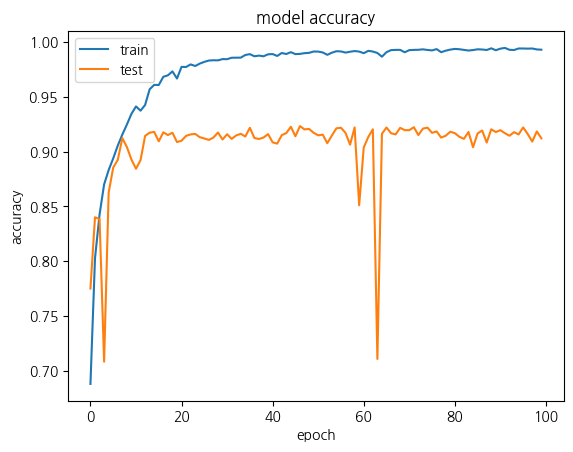

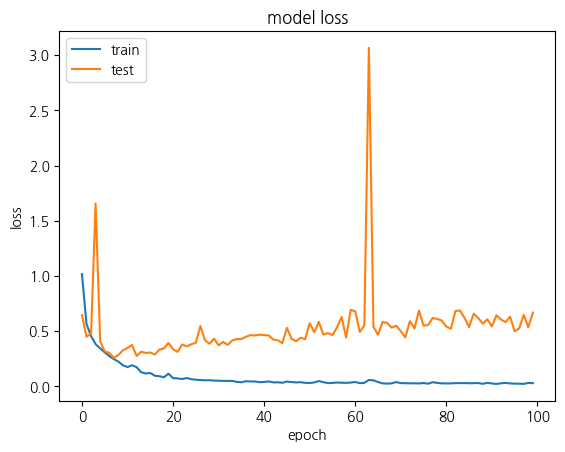

In [41]:
#학습결과 시각화
plt.plot(model_fit_history.history['accuracy'])
plt.plot(model_fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(model_fit_history.history['loss'])
plt.plot(model_fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
#테스트 데이터셋으로 평가 진행
model_evaluate_result = model.evaluate(test_images, test_labels, batch_size=1)

2023-04-21 00:02:23.513023: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1991485440 exceeds 10% of free system memory.
2023-04-21 00:02:24.215575: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1991485440 exceeds 10% of free system memory.


13230/13230 [==============================] - 41s 3ms/step - loss: 0.7205 - accuracy: 0.9150 - recall: 0.9129 - precision: 0.9181 - f1_score: 0.9134


In [45]:
print("test loss, test acc:", model_evaluate_result)

test loss, test acc: [0.7204656600952148, 0.9150415658950806, 0.9129251837730408, 0.9180601835250854, 0.9134125113487244]


In [46]:
with tf.device('CPU'):
    all_train_image, all_train_label = load_images_and_labels(all_train_images)
    model_predict = model.predict(all_train_image).argmax(axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90000/90000 [00:07<00:00, 12158.42it/s]


2813/2813 [==============================] - 201s 72ms/step


In [47]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

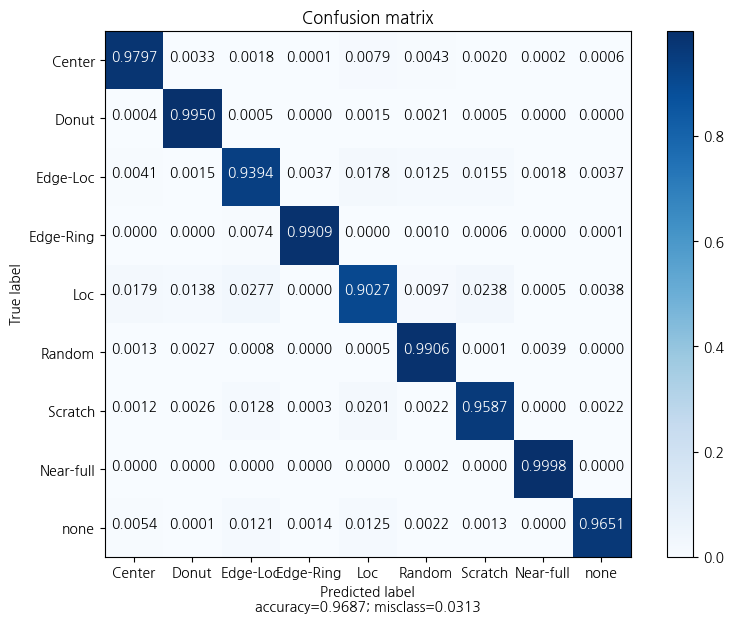

In [48]:
confusion_result = confusion_matrix(all_train_label, model_predict, normalize='pred')
plot_confusion_matrix(confusion_result, target_names=wf_train_labels, labels=True, normalize=True)

In [49]:
print(classification_report(all_train_label, model_predict))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     10000
           1       0.98      1.00      0.99     10000
           2       0.94      0.94      0.94     10000
           3       0.99      0.99      0.99     10000
           4       0.94      0.90      0.92     10000
           5       0.97      0.99      0.98     10000
           6       0.96      0.96      0.96     10000
           7       0.99      1.00      1.00     10000
           8       0.99      0.96      0.98     10000

    accuracy                           0.97     90000
   macro avg       0.97      0.97      0.97     90000
weighted avg       0.97      0.97      0.97     90000

